# Network data import from OpenStreetMap

This noteboook demonstrates how to import network data from [OpenStreetMap](https://www.openstreetmap.org/) (OSM). This is enabled by [OSMnx](https://geoffboeing.com/publications/osmnx-complex-street-networks/) ([github](https://github.com/gboeing/osmnx)), a Python package for OSM data handling. OSMnx is an optional module for UXsim. If you haven't installed it, please install it first.

WARNING: Import from OSM is experimental and may not work as expected. It is functional but produces inappropriate networks for simulation, such as too many nodes, too many deadends, fragmented networks.

## Network import

Now, define UXsim World as always.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [13]:

from uxsim import *

W = World(
    name="",
    deltan=5,
    tmax=7200,
    print_mode=1, save_mode=1, show_mode=0, 
    random_seed=0
)

We are going to import the highway network in Tokyo. `OSMImporter` class summarizes the related functions.

The area is specified by lon/lat coordinates. 

`custom_filter='["highway"~"motorway"]'` means only `motorway` links are imported. If you want to import major arterial roads, you may use `custom_filter='["highway"~"trunk|primary"]'`. For the details, please see [OSMnx documentation](https://osmnx.readthedocs.io/en/stable/user-reference.html).

In [14]:
nodes, links = OSMImporter.import_osm_data(north=35.817, south=35.570, east=139.881, west=139.583, custom_filter='["highway"~"motorway"]')

Start downloading OSM data. This may take some time.


Download completed
imported network size:
 number of links: 812
 number of nodes: 718


Below shows the imported network data.

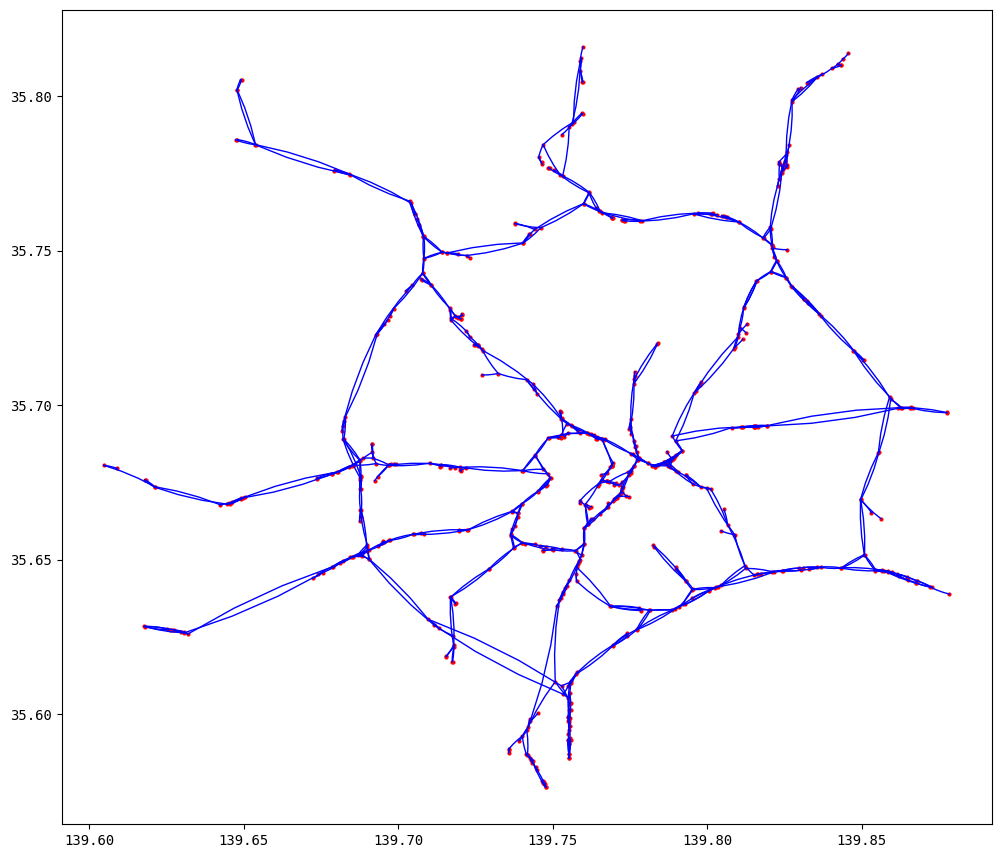

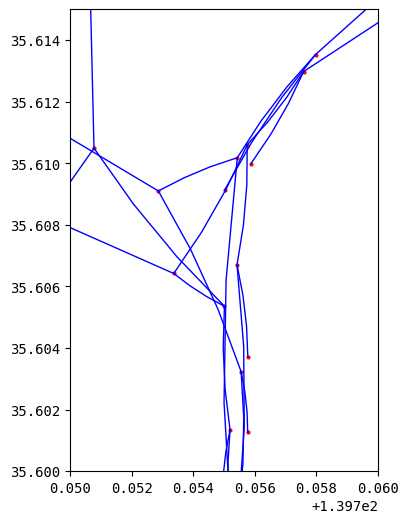

In [15]:
OSMImporter.osm_network_visualize(nodes, links, show_link_name=0)
OSMImporter.osm_network_visualize(nodes, links, show_link_name=0, xlim=[139.75, 139.76], ylim=[35.60, 35.615], figsize=(6,6))

Unfortunately, the raw data is too detailed and not suitable for UXsim simulation. For example, many intersections of OSM consists of 4 nodes and may create strange traffic simulation results such as gridlocks.
    
Therefore, postprocessing is required to make the network suitable for simulation as follows. First, it aggregates the network by merging nodes that are closer than the threshold (0.05 degree ~= 500 m). Second, we add reverse links for each link to eliminate dead-end nodes as much as possible. WIthout it, a lot of vehicles will lost their way and loiter the network randomly. Please be aware that in this postprocessing the original network topology is not preserved rigorously. This function is just for convenience; if you need rigorous network data, you have to manually adjust it.

`OSMImporter.osm_network_to_World` will load the postprocessed network into the World.

In [20]:
nodes, links = OSMImporter.osm_network_postprocessing(nodes, links, node_merge_threshold=0.005, node_merge_iteration=5, enforce_bidirectional=True)
OSMImporter.osm_network_to_World(W, nodes, links, default_jam_density=0.2, coef_degree_to_meter=111000)

aggregated network size:
 number of links: 658
 number of nodes: 273


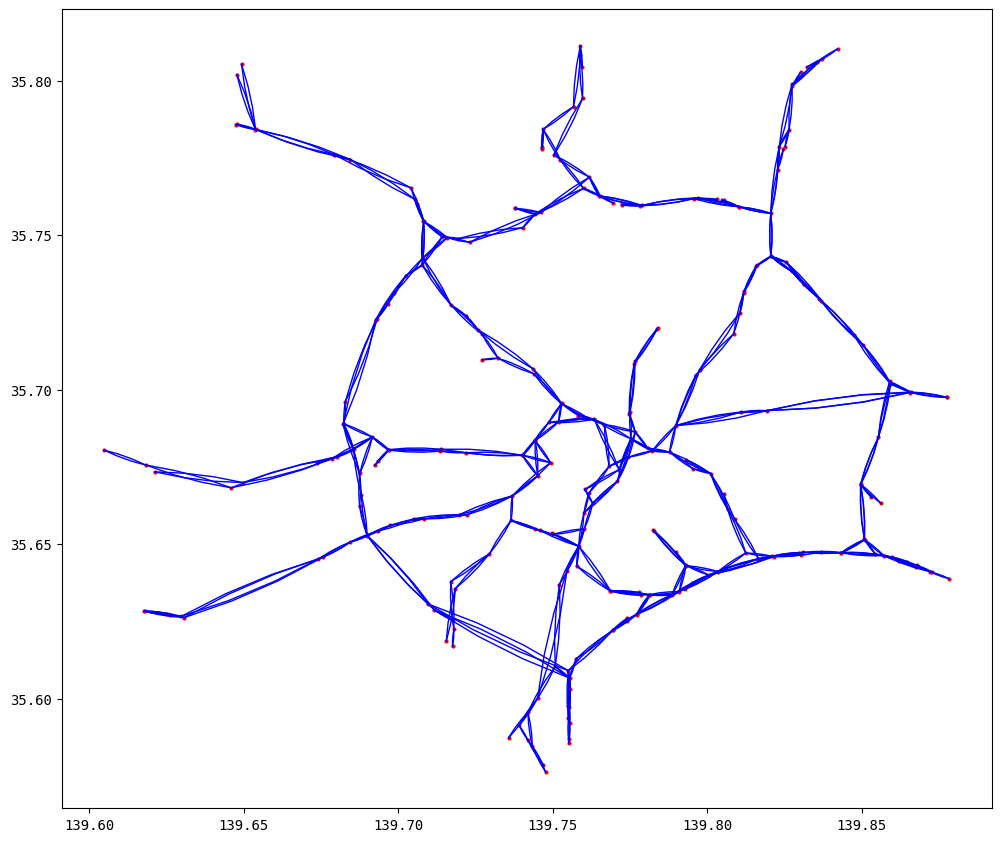

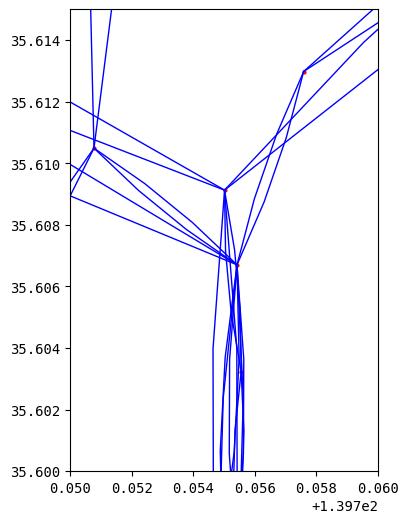

In [21]:
OSMImporter.osm_network_visualize(nodes, links, show_link_name=0)
OSMImporter.osm_network_visualize(nodes, links, show_link_name=0, xlim=[139.75, 139.76], ylim=[35.60, 35.615], figsize=(6,6))

As a result, the network data is significantly simplified.

## Demand

The travel demand is now defined using coordinates. Below add demand from a circular area to another circular area. It represents demand to central Tokyo from surroundings.

In [22]:
W.adddemand_area2area(139.70, 35.60, 0, 139.75, 35.68, 0.05, 0, 3600, volume=5000)
W.adddemand_area2area(139.65, 35.70, 0, 139.75, 35.68, 0.05, 0, 3600, volume=5000)
W.adddemand_area2area(139.75, 35.75, 0, 139.75, 35.68, 0.05, 0, 3600, volume=5000)
W.adddemand_area2area(139.85, 35.70, 0, 139.75, 35.68, 0.05, 0, 3600, volume=5000)

## Simulation and results

Now you can execute the simulation.

In [23]:
W.exec_simulation()

simulation setting:
 scenario name: 
 simulation duration:	 7200 s
 number of vehicles:	 18900 veh
 total road length:	 911654.2133305998 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 1440
 number of platoons:	 3780
 number of links:	 658
 number of nodes:	 273
 setup time:		 114.70 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|     1220 vehs|  13.9 m/s|     2.28 s
    1200 s|     3090 vehs|  12.8 m/s|     4.13 s
    1800 s|     4060 vehs|  12.1 m/s|     6.22 s
    2400 s|     4270 vehs|  11.9 m/s|     8.36 s
    3000 s|     4435 vehs|  12.2 m/s|    10.46 s
    3600 s|     4435 vehs|  11.9 m/s|    12.45 s
    4200 s|     4360 vehs|  12.0 m/s|    14.39 s
    4800 s|     4350 vehs|  11.7 m/s|    16.14 s
    5400 s|     4355 vehs|  11.8 m/s|    17.77 s
    6000 s|     3435 vehs|  10.7 m/s|    19.30 s
    6600 s|     2445 vehs|  10.4 m/s|    20.65 s
    7195 s|     1590 vehs|  

1

results:
 average speed:	 12.1 m/s
 number of completed trips:	 16840 / 18900
 average travel time of trips:	 2547.3 s
 average delay of trips:	 1280.5 s
 delay ratio:			 0.503
 generating animation...


  0%|          | 0/60 [00:00<?, ?it/s]

 generating animation...


  0%|          | 0/720 [00:00<?, ?it/s]

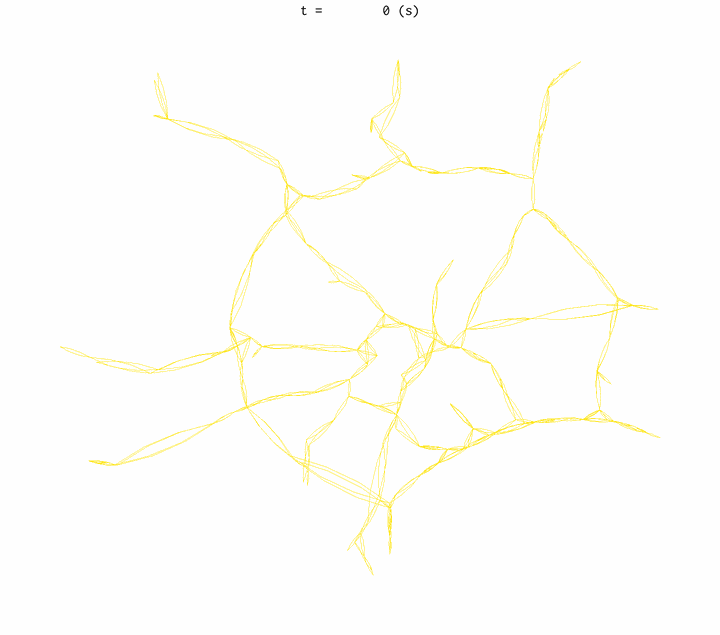

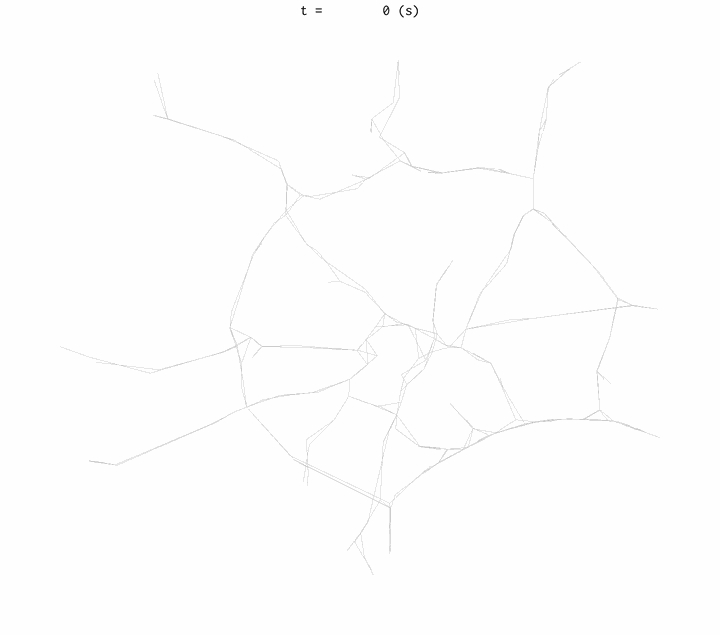

In [27]:
W.analyzer.print_simple_stats()
W.analyzer.network_anim(animation_speed_inverse=15, detailed=0, network_font_size=0)
W.analyzer.network_fancy(animation_speed_inverse=15, sample_ratio=0.1, interval=10, trace_length=5)

from IPython.display import display, Image
with open("out/anim_network0.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))
with open("out/anim_network_fancy.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))

Now we get somewhat plausible results. Traffic from outskirts goes to the central Tokyo, causing traffic congestion due to the concentration. 

Note that the above results is not realistic. To obtain realistic results, you have to calibrate demands and scenario parameters very carefully. This is generally very difficult.